# Augmentation 
This notebook is related to exploration and creation of prominent advesarial unlabelled data. Three main mechanism is implemented:
1. Word synonym replacement.
2. Word context replacement using langauge models
3. BackTranslation

Approach:
1. Splitting training dataset in three parts, one for word synonym replacement, second for word replacement using langauge models, and the last one for back translation. 
2. Goal is to generate 3 times more data than training data. so, during training we can adjust the ratio between labeled and unlabeled data. 

__Date June 27 :__
- Implementing changing most important word in case of synonym replacement. 
- And, after generating the adversarial text we need to check the similarity score between original text and adversarial text then keep only most similar article (using some threshold). And, constraint would be minimum percentage of perturbation(again introducting some threshold).

__Date July 1 :__
- Implementing the perturbation percentage.Formula would be number of words changed divided by total words.

__Date July 3 :__
- Changing in the strategy of synonym change and including ranking words as per attack.
- Evaluation code for langauge model.


# Import and Installation

In [2]:
!pip install nlpaug
!pip install transformers
!pip install torch
!pip install fastBPE sacremoses
!pip install hydra-core
!pip install omegaconf
!pip install sentencepiece==0.1.94
!pip install mosestokenizer==1.1.0
!pip install semantic-text-similarity
!pip install textattack
!pip install tensorflow-text

     |████████████████████████████████| 409 kB 5.4 MB/s 
     |████████████████████████████████| 11.3 MB 29.6 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


     |████████████████████████████████| 3.1 MB 5.5 MB/s 
     |████████████████████████████████| 596 kB 46.2 MB/s 
     |████████████████████████████████| 895 kB 38.7 MB/s 
     |████████████████████████████████| 59 kB 830 kB/s 
     |████████████████████████████████| 3.3 MB 34.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=483116 sha256=71e30c543b315ac5467984c423530bb20f6c2ba9890e67487ba3c47dec24dbd9
  Stored in directory: /root/.cache/pip/wheels/bd/d4/0e/0d317a65f77d3f8049fedd8a2ee0519164cf3e6bd77ef886f1
Successfully built fastBPE
     |████████████████████████████████| 145 kB 5.3 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 112 kB 43.6 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.wh

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
  Created wheel for mosestokenizer: filename=mosestokenizer-1.1.0-py3-none-any.whl size=49117 sha256=1e2f48844ace60b99cb42cbfeb669867396a322954474416700230f03a29af8d
  Stored in directory: /root/.cache/pip/wheels/a7/31/94/fef279382208e85a65c1a7f5c4d0020115477b0af74f296b57
  Created wheel for toolwrapper: filename=toolwrapper-2.1.0-py3-none-any.whl size=3354 sha256=e60681be01cc5f71d6c42d55edbe08170ee668cb6bfcae3f1c6288f5065f08c1
  Stored in directory: /root/.cache/pip/wheels/c5/4f/33/54741ffe08e38ececb1d28068a153729b4fe820bafa0a0691f
  Created wheel for uctools: filename=uctools-1.3.0-py3-none-any.whl size=6163 sha256=85561afc120d209270f92cddff3e687b26d6236cce503dd94d8bbbc04b70e4e7
  Stored in directory: /root/.cache/pip/wheels/fb/44/e9/914cf8fa71f0141f9314f862538d1218fcf2b94542a0fb7d35
Successfully built mosestokenizer toolwrapper uctools
     |████████████████████████████████| 416 kB 5.4 MB/s 
     |█████████████████████████████

In [1]:
import transformers
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import os
import pandas as pd 
import numpy as np 
from transformers import MarianMTModel, MarianTokenizer
import tensorflow as tf

import random
from sklearn.metrics import accuracy_score, classification_report

from ipywidgets import *
from IPython.display import display
from ipywidgets import *

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
random.seed(42)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Reading Data

In [2]:
os.chdir('/content/drive/MyDrive/Master Thesis/Mean-Teacher-BERT-Robustness-Assessment/')
main_dir='Data/'

In [3]:


# dataset names are codalab, IMDB,...
dataset_folder_name=widgets.Text(value='codalab',placeholder='Enter Dataset Name',description='Dataset Name',disabled=False)

# feature declaration 
# target_col='label'
# feature_col='tweet'
feature_col=widgets.Text(value='tweet',placeholder='Enter Feature Col Name',description='Feature Column:',disabled=False)
target_col=widgets.Text(value='label',placeholder='Enter Target Col Name',description='Target Column:',disabled=False) 

tf.print('Enter the dataset name')
display(dataset_folder_name)
tf.print('Enter Feature column name')
display(feature_col)
tf.print('Enter Target column name')
display(target_col)

#global parameter declaration 

# feature_col="tweet" # as we only need feature in creating the prominent unlabeld dataset
aug_col='aug_tweet'
# target_col='label'
perturb_col= 'Perturbation%'

# augmentation parameter 
max_word_aug=10 # adjust this parameter to change the word level augmentation
max_len=100

pretrained_weights= 'bert-base-uncased'

Enter the dataset name


Text(value='codalab', description='Dataset Name', placeholder='Enter Dataset Name')

Enter Feature column name


Text(value='tweet', description='Feature Column:', placeholder='Enter Feature Col Name')

Enter Target column name


Text(value='label', description='Target Column:', placeholder='Enter Target Col Name')

In [4]:
# if we want to add augmentation on raw data 
# train_loc= 'codalab/RawData.csv'

# incase of preprocess data preprocess data
proc_train_loc=os.path.join(main_dir,dataset_folder_name.value+'/PreprocessedData/pr_train.csv')

#test dataset
test_loc=os.path.join(main_dir,dataset_folder_name.value+'/PreprocessedData/pr_test.csv')


In [5]:
#reading dataset
adv_unlabel_df= pd.read_csv(proc_train_loc,
                           header='infer',
                           usecols=[feature_col.value,target_col.value]) 

adv_unlabel_df= adv_unlabel_df.dropna().reset_index(drop=True)
adv_unlabel_df

,review,sentiment
0,i will keep this as short as possible as this ...,negative
1,i watched this expecting to see the usual itis...,positive
2,i thought this movie was absolutely hilarious ...,positive
3,chucky s back and it s about time this time ...,positive
4,this movie was not only disappointing to the h...,negative
...,...,...
6045,michael myers the deranged not so young anym...,negative
6046,sequels hardly ever live up to the original t...,positive
6047,after looking at monkeys oops apes for more ...,negative
6048,my other and i have pokemon 4ever on dvd we w...,positive


In [ ]:
# adversarial test data 
# adv_test_df= pd.read_csv(test_loc,header='infer',index_col=[0])
# adv_test_df= adv_test_df.dropna().reset_index(drop=True)
# adv_test_df.head(), adv_test_df.shape

(                                               tweet label
 0  our daily update is published state reported 7...  real
 1                 alfalfa is the only cure for covid  fake
 2  president trump asked what he would do if he w...  fake
 3  state reported death we are still seeing a sol...  real
 4  this is the sixth time a global health emergen...  real, (2042, 2))

# Function declaration

In [8]:
#splitting the dataset 
def df_splitter(df,num_of_partition=3):
    '''Function to split the dataframe into num_of_partition
     portion via sampling technique,and return three dataframe, 
     in zip format RETURN: Collection of Dataframe'''

    partition_ratio= 1/num_of_partition
    collection=[]

    for i in range(num_of_partition):
        # this need to perform to get random sample from if we are using df.sample.
        random_state= np.random.choice(np.random
                                       .randint(1,100))

        collection.append(df.sample(frac=partition_ratio,
                                    replace=True,
                                    random_state=random_state)
                                    .reset_index(drop=True))

    return collection

# Synonyn Augmentation
def synonym_augment(df,max_aug=10,aug_src='wordnet', iter=2):
    '''Synonym Based Augmentation: To augment data 
    with max_aug synonym in the given articles, 
    we can change aug_src ['ppdb']
    RETURN: Dataframe'''
    print('Executing synonym augmentation')
    df_aug=pd.DataFrame()
    aug=naw.SynonymAug(aug_src=aug_src,
                       aug_max=max_aug)
    try:
        for i in range(iter):
            df[aug_col]= aug.augment(list(df[feature_col.value].values))
            df_aug=df_aug.append(df)   
    except e:
        print(e)
        pass

    return df_aug.reset_index(drop=True)

#Context Augmentation
def context_augment(df,pretrained_model='distilbert-base-uncased',action='substitute',iter=1):
    '''Context Based Augmentation: To augment data using langauge model 
    the given articles, we can change pretrained_model to different language model.
    RETURN: Dataframe'''

    #this need to perform as above 512 can crash the system.
    print('Executing context augmentation')
    # df=df[(df[feature_col.value].str.len()<=100)&(df[feature_col.value].str.len()>5)]
    #augmentor
    try:
        aug=naw.ContextualWordEmbsAug(model_path=pretrained_model,
                                    action=action)
        
        df_aug=pd.DataFrame()
        for i in range(iter):
            df[aug_col]= aug.augment(list(df[feature_col.value].values))
            df_aug=df_aug.append(df)
    except Exception as e:
        print(e)
    return df_aug.reset_index(drop=True)

#Back-translation Augmentation
def back_translation(df):
    '''Function to create dataframe using backtranslation
     technique usign Marian tokenizer. RETURN: Dataframe'''
    
    print('Executing Backtranslation augmentation')

    # english to romance
    target_model_name = 'Helsinki-NLP/opus-mt-en-ROMANCE'
    tokenizer = MarianTokenizer.from_pretrained(target_model_name)
    model = MarianMTModel.from_pretrained(target_model_name)
    
    #romance to english
    en_model_name = 'Helsinki-NLP/opus-mt-ROMANCE-en'
    en_tokenizer = MarianTokenizer.from_pretrained(en_model_name)
    en_model = MarianMTModel.from_pretrained(en_model_name)
    
    def translated_texts(text):
        translated = model.generate(**tokenizer([text], return_tensors="pt", padding=True))
        rom_texts = tokenizer.decode(translated[0], skip_special_tokens=True) 

        back_translated = en_model.generate(**en_tokenizer(rom_texts, return_tensors="pt", padding=True))
        translated_texts = en_tokenizer.decode(back_translated[0], skip_special_tokens=True).lower()

        return translated_texts

    #taking less than 200 length
    # df_back_translation= df[(df[feature_col.value].str.len()<=200) & (df[feature_col.value].str.len()>0)].reset_index(drop=True)
    df_back_translation= df[(df[feature_col.value].str.len()>0)].reset_index(drop=True)
    # print(df_back_translation.shape)
    df_back_translation[aug_col]=df_back_translation[feature_col.value].apply(lambda row: translated_texts(row))

    return df_back_translation


def data_cleaning(df):
    '''
    This function will check and remove rows which has :
    - Augmented tweet and original text are same 
    - if length of the augmented text(unique words count ) is less than 3
    '''
    print(f'Initial Length of the dataframe: {len(df)}')
    print(f'Number of same augmented text  and original text:{len(df)-len(df[~(df[feature_col.value]==df[aug_col])])}')
    df=df[~(df[feature_col.value]==df[aug_col])].reset_index(drop=True)
    print(f'After removinal : {len(df)}')

    # unique words replacement
    df['set_aug']= df[aug_col].apply(lambda row: len(set(row.split(' '))))
    df=df[~(df['set_aug']<3)].reset_index(drop=True)
    print(f'Length after dropping less than 3 unique words in the augtweet: {len(df)}')
    

    return df[df.columns.difference(['set_aug'])]



# Data Augmentation

In [ ]:

df_syn,df_context,df_back_translated=df_splitter(adv_unlabel_df)

#Creating Unlabel data 
with tf.device('/device:GPU:0'):
    augment_data_loc=os.path.join(main_dir,dataset_folder_name.value+'/AugmentedData/')
    df_syn= synonym_augment(df_syn,max_aug=20)
    df_syn= data_cleaning(df_syn)

    df_syn.to_csv(augment_data_loc+'aug_synonym.csv', index=False)

    df_context= context_augment(df_context)
    df_context=data_cleaning(df_context)
    df_context.to_csv(augment_data_loc+'aug_context.csv', index=False)

    df_back_translated= back_translation(df_back_translated)
    df_back_translated=data_cleaning(df_back_translated)
    df_back_translated.to_csv(augment_data_loc+'aug_backtranslated.csv', index=False)


# Adversarial test data 
'''
Now its not required, we only need train augmentated data
'''
# '''Here I am creating three different adversarial dataset, to observe the effects of different attacks'''
# print('Executing test data')
# with tf.device('/device:GPU:0'):
#     # keeping max aug less in order to prevent it from lossing semantics
#     adv_test_syn_df=synonym_augment(adv_test_df,max_aug=10,iter=1) 
#     adv_test_syn_df= data_cleaning(adv_test_syn_df)
#     adv_test_syn_df.to_csv('codalab/AugmentedData/adv_test_syn.csv', index=False)

#     adv_test_context_df=context_augment(adv_test_df,iter=1) # keeping max aug less in order to prevent it from lossing 
#     adv_test_context_df= data_cleaning(adv_test_context_df)
#     adv_test_context_df.to_csv('codalab/AugmentedData/adv_test_context.csv', index=False)

    #     adv_test_backTrans_df= back_translation(adv_test_df)
    #     adv_test_backTrans_df= data_cleaning(adv_test_backTrans_df)
#     adv_test_backTrans_df.to_csv('codalab/AugmentedData/adv_test_backTrans.csv', index=False)

Executing synonym augmentation
Initial Length of the dataframe: 4034
Number of same augmented text  and original text:0
After removinal : 4034
Length after dropping less than 3 unique words in the augtweet: 4034
Executing context augmentation


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
df_syn.shape, df_context.shape, df_back_translated.shape,adv_unlabel_df.shape

# Similarty Exploration

In [ ]:
os.chdir('/content/drive/MyDrive/Master Thesis/')

#reading the augmented test data for exploration
adv_test_syn_df= pd.read_csv('codalab/AugmentedData/adv_test_syn.csv')
adv_test_context_df= pd.read_csv('codalab/AugmentedData/adv_test_context.csv')
adv_test_backTrans_df= pd.read_csv('codalab/AugmentedData/adv_test_backTrans.csv')
adv_test_syn_df.head()

,aug_tweet,label,tweet,CosineSim,Wmd,Semantic_sim
0,our daily update is published state reported 7...,real,our daily update is published state reported 7...,0.853411,0.186420,4.611340
1,alfalfa is the alone cure for covid,fake,alfalfa is the only cure for covid,0.752320,0.140226,4.618185
2,president trump ask what he would do if he be ...,fake,president trump asked what he would do if he w...,0.820021,0.147841,4.717221
3,state reported death we follow still seeing a ...,real,state reported death we are still seeing a sol...,0.759327,0.160945,4.360808
4,this is the sixth fourth dimension a global we...,real,this is the sixth time a global health emergen...,0.713065,0.295865,4.121512


In [ ]:
def perturb_cal(row):
  '''
  This function calculate perturbation percentage 
  in the augmented text w.r.t original text.
  Formula is counting word difference/length of original text
  '''
  list1=row[feature_col].split()
  list2=row[aug_col].split()
  count=0
  for w1,w2 in zip(list1,list2):
    if w1!=w2:
      count+=1
  perturb_per= round((count/len(list1))*100,3)
  return perturb_per

adv_test_syn_df[perturb_col]=adv_test_syn_df.apply(lambda row: perturb_cal(row),axis=1)
adv_test_syn_df

,aug_tweet,label,tweet,CosineSim,Wmd,Semantic_sim,Perturbation%
0,our daily update is published state reported 7...,real,our daily update is published state reported 7...,0.853411,0.186420,4.611340,8.000
1,alfalfa is the alone cure for covid,fake,alfalfa is the only cure for covid,0.752320,0.140226,4.618185,14.286
2,president trump ask what he would do if he be ...,fake,president trump asked what he would do if he w...,0.820021,0.147841,4.717221,12.500
3,state reported death we follow still seeing a ...,real,state reported death we are still seeing a sol...,0.759327,0.160945,4.360808,66.667
4,this is the sixth fourth dimension a global we...,real,this is the sixth time a global health emergen...,0.713065,0.295865,4.121512,84.000
...,...,...,...,...,...,...,...
1978,a major fear be that specificity be not test u...,real,a major concern is that specificity is not tes...,0.559163,0.291761,4.164474,51.724
1979,rt whoafro the covid virus hasnt been found to...,real,rt whoafro the covid virus hasnt been found to...,0.907733,0.206634,4.570009,40.909
1980,tonight midnight onwards catastrophe managemen...,fake,tonight midnight onwards disaster management a...,0.825504,0.110223,4.597428,39.024
1981,new casing of covid 19nigeria plateau enugu oy...,real,new case of covid 19nigeria plateau enugu oyo ...,0.795133,0.200797,3.802569,11.538


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
from semantic_text_similarity.models import WebBertSimilarity
from semantic_text_similarity.models import ClinicalBertSimilarity

wmd_model = api.load('word2vec-google-news-300')
vectorizer = TfidfVectorizer()
web_model = WebBertSimilarity(device='cpu', batch_size=10)

def wmd(text1,text2):
  '''
  Function to calculate the word moving distance between two text statements.
  0- means same sentence 
  >0- some differences in the sentences
  '''
  return  wmd_model.wmdistance(text1, text2)

def cosine_sim(text1, text2):
  '''
  Function to calculate the cosine similarity between two statements.
  0- NO similarity
  1- Same sentence
  '''
  tfidf = vectorizer.fit_transform([text1, text2])
  return ((tfidf * tfidf.T).A)[0,1]

def semantic_sim(text1,text2):
  '''
  Function to calculate the sematic similarity between texts 
  0- No similarity
  5- Same sentence
  '''
  return web_model.predict([(text1,text2)])[0]
  
def similarity_exploration(df):
  '''
  Adding similarity column in the dataframe.
  '''
  df['CosineSim']= df.apply(lambda row: cosine_sim(row[aug_col],row[feature_col]),axis=1)
  df['Wmd']= df.apply(lambda row: wmd(row[aug_col],row[feature_col]),axis=1)
  df['Semantic_sim']= df.apply(lambda row: semantic_sim(row[aug_col],row[feature_col]),axis=1)
  return df

In [ ]:
adv_test_syn_df= similarity_exploration(adv_test_syn_df)

adv_test_context_df=similarity_exploration(adv_test_context_df)

adv_test_backTrans_df=similarity_exploration(adv_test_backTrans_df)


## Saving the files


In [ ]:
adv_test_syn_df.to_csv('codalab/AugmentedData/adv_test_syn.csv', index=False)
adv_test_context_df.to_csv('codalab/AugmentedData/adv_test_context.csv', index=False)
adv_test_backTrans_df.to_csv('codalab/AugmentedData/adv_test_backTrans.csv', index=False)

,aug_tweet,label,tweet,CosineSim,Wmd,Semantic_sim
0,president trump asked what he would do if he c...,fake,president trump asked what he would do if he w...,0.815061,0.181594,4.665123
1,an independent predictor of worse prognosis in...,real,low vitamind wa an independent predictor of wo...,0.729728,0.366763,3.140324
2,to say that the law of aid coronavirus of reli...,fake,say the coronavirus aid relief and economic se...,0.628013,0.373009,4.312288
3,a child reaches this stage of fucking blockage,fake,kid reach f k this shit stage of lockdown,0.275196,0.706068,1.935341
4,icu are totally forcing covidant patient to wa...,real,icu are full forcing covid patient to wait hou...,0.615521,0.205245,4.461790
...,...,...,...,...,...,...
590,hot water steam inhalation steam kill home vir...,fake,inhaling hot water steam kill corona virus hom...,0.486416,0.263234,3.856449
591,total death achieved state reported death date...,real,total death reached state reported covid death...,0.580373,0.246589,3.278967
592,our number of coves are better than most of th...,fake,our covid number are better than almost all co...,0.390186,0.453013,3.065197
593,the asymptomatic propagation coronavirus coron...,real,asymptomatic coronavirus spread is rare who say,0.324932,0.431581,4.695443


# Evaluation of the model 

In [ ]:
from transformers import AutoTokenizer, TFAutoModel, TFDistilBertModel, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf 
from tensorflow.keras.layers import LSTM, Bidirectional,Dropout, Dense, Embedding, Input 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical

max_len= 100
learning_rate= 2e-5 

def bert_model(max_len,pretrained_weights):
    '''BERT model creation with pretrained weights
    max_len: input length '''
    bert=TFAutoModel.from_pretrained(pretrained_weights)
    for layer in bert.layers:
        layer.trainable = True
    # parameter declaration
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # declaring inputs, BERT take input_ids and attention_mask as input
    input_ids= Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
    attention_mask=Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')
    bert= bert(input_ids,attention_mask=attention_mask)
    x= bert[0][:,0,:]
    x=tf.keras.layers.Dropout(0.2)(x)
    x= tf.keras.layers.Dense(64)(x)
    x=tf.keras.layers.Dense(32)(x)
    output=tf.keras.layers.Dense(2,activation='sigmoid')(x)
    model=Model(inputs=[input_ids,attention_mask],outputs=[output])
    # compiling model 
    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])
    return model

def label_to_int(row):
    if row=='real':
        return 0
    else:
        return 1
# Converting to categories 
def convert_to_category(target, n_classes=2):
    return [to_categorical(target,n_classes)]
    
#creating the tokenizer
def create_tokenizer(pretrained_weights='distilbert-base-uncased'):
    '''Function to create the tokenizer'''
    # print(pretrained_weights)
    tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
    return tokenizer



# sentence tokenization
def sent_tokenization(sentence,pretrained_weights,max_len):
    '''dataset: Pandas dataframe with feature name is column name 
    Pretrained_weights: selected model 
    RETURN: [input_ids, attention_mask]'''
    tokenizer=create_tokenizer(pretrained_weights)
    tokens=tokenizer(sentence,return_tensors='tf', 
              truncation=True,
              padding='max_length',
              max_length=max_len, 
              add_special_tokens=True)
    return [tokens.input_ids,tokens.attention_mask]

def evaluation(model,x_test,y_test):
    '''
    Evaluation of the model in case you have test data in numpy array format
    Return- predicted label and accuracy
    '''
    y_pred= model.predict(x_test)
    confidence=np.around((y_pred *100),decimals=3)
    if y_pred.shape[1]>1:
        y_pred=tf.argmax(y_pred,1)
        y_true=tf.argmax(y_test,1)
    else:
        y_true=y_test
    cl_r=classification_report(y_true,y_pred,output_dict=True)
    # print(classification_report(y_true,y_pred))
    return confidence,y_pred,y_true,cl_r['accuracy']
    
def pred_pipeline(model,sentence,label):
  # tokenization 
  x_sent= sent_tokenization(sentence,pretrained_weights,max_len)
  # evaluation
  conf,pred,true,acc= evaluation(model,x_sent,label)
  if true==1:
    print('Original-->Fake')
  else:
    print('Original-->Real')
  if pred==1:
    print('Predicted-->Fake')
  else:
    print('Predicted-->Real')

  # print('Accuracy:', acc)
  return conf,true.numpy()[0],pred.numpy()[0]

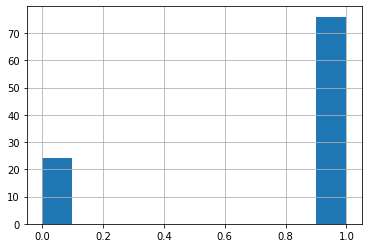

In [ ]:
aug_test_df=adv_test_df[(adv_test_df[feature_col].str.len()>=10) & (adv_test_df[feature_col].str.len()<=100)][:100].reset_index(drop=True)
aug_test_df[target_col]=aug_test_df[target_col].apply(lambda row: label_to_int(row) ).astype(int)
aug_test_df[target_col].hist()


In [ ]:
tokenizer=create_tokenizer(pretrained_weights)

In [ ]:
# what is the performance of this data with the model
BERT_model= bert_model(max_len,pretrained_weights) 
BERT_model.load_weights('SavedModels/BERT_model.h5')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
aug_test_df[target_col]= aug_test_df[target_col].apply(lambda row: convert_to_category(row))

In [ ]:
pred_pipeline(BERT_model,aug_test_df[feature_col][0],aug_test_df[target_col][0])

In [ ]:
result=[]
for i in range(1,len(aug_test_df)):
  result.append(pred_pipeline(BERT_model,aug_test_df.loc[i,feature_col],aug_test_df.loc[i,target_col]))

In [ ]:
result= np.array(result)
result

In [ ]:
# accuracy calculation
np.count_nonzero((result[:,1]==result[:,2]).astype(int))/len(result)

0.9393939393939394

In [ ]:
sf,lf=aug_test_df[feature_col][0],aug_test_df[target_col][0]
sf,lf

('alfalfa is the only cure for covid', [array([0., 1.], dtype=float32)])

In [ ]:
s1=aug_test_df[feature_col][1]
l1=aug_test_df[target_col][1]
s1,l1

('president trump asked what he would do if he were to catch the coronavirus donaldtrump coronavirus',
 [array([0., 1.], dtype=float32)])

In [ ]:
pred_pipeline(BERT_model,sf,lf)

Original-->Fake
Predicted-->Fake


(array([[ 0, 99]]), 1, 1)

In [ ]:
from nltk.corpus import wordnet 
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
def synonym_sent_augment(sent,max_aug=20,aug_src='wordnet', iter=20):
    '''Synonym Based Augmentation: To augment data 
    with max_aug synonym in the given articles, 
    we can change aug_src ['ppdb']
    RETURN: Dataframe'''
    aug=naw.SynonymAug(aug_src=aug_src,
                       aug_max=max_aug)
    aug_sent=[]
    try:
        for i in range(iter):
            aug_sent.append(aug.augment(sent))
    except Exception as e:
        print(e)
        pass

    return aug_sent
aug_s_list=synonym_sent_augment(sf)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
prominent_aug=[]
aug_s_list=sf.split()
for item in aug_s_list:
  print(item)
  conf,true,pred= pred_pipeline(BERT_model,item,lf)
  print(conf)
  if true!=pred:
    prominent_aug.append(item)
prominent_aug


In [ ]:
tok=sf.split(' ')
imp_word=[]
print('sentence:', sf)
for i,item in enumerate(tok):
  synset=wordnet.synsets(item)
  print('--------------')
  if synset:
    r_word=synset[0].lemmas()[0].name()
    new_s=sf.replace(item,r_word)
  else:
    continue
  print(f'{item}-->{r_word}')
  conf,true,pred=pred_pipeline(BERT_model,new_s,lf)
  print(np.around(conf,decimals=3))
  if true!=pred:
    imp_word.append([item,r_word])

imp_word

sentence alfalfa is the only cure for covid
--------------
alfalfa-->alfalfa
Original-->Fake
Predicted-->Fake
[[7.5000e-02 9.9885e+01]]
--------------
is-->be
Original-->Fake
Predicted-->Fake
[[ 0.298 99.627]]
--------------
--------------
only-->lone
Original-->Fake
Predicted-->Fake
[[8.0000e-02 9.9901e+01]]
--------------
cure-->remedy
Original-->Fake
Predicted-->Fake
[[6.9000e-02 9.9876e+01]]
--------------
--------------


[]

In [ ]:
pred_pipeline(BERT_model,
              sf,
              lf)

Original-->Fake
Predicted-->Fake


(array([[7.5000e-02, 9.9885e+01]], dtype=float32), 1, 1)

In [ ]:
pred_pipeline(BERT_model,
              'corona',
              lf)

Original-->Fake
Predicted-->Fake


(array([[ 1.388, 98.576]], dtype=float32), 1, 1)

In [ ]:
pred_pipeline(BERT_model,
              'two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting  by covid black people also have much higher instance of vitamin d deficiency v in the general population'
              ,lf)


Original-->Fake
Predicted-->Real


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([[59, 41]]), 1, 0)

In [ ]:
sf

'two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting slammed by covid black people also have much higher instance of vitamin d deficiency v in the general population'

In [ ]:
pred_pipeline(BERT_model,
              'higher',
              lf)

Original-->Fake
Predicted-->Real


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([[98,  4]]), 1, 0)

     |████████████████████████████████| 4.4 MB 5.4 MB/s 


# Text attack augmentation

In [ ]:
!pip install --user numpy
!pip install --user  pandas

In [ ]:
import pandas as pd 
import numpy as np

df=pd.read_csv('/content/drive/MyDrive/Master Thesis/Mean-Teacher-BERT-Robustness-Assessment/Data/IMDB/PreprocessedData/pr_train.csv',index_col=[0])
df[:10].to_csv('test.csv')

In [ ]:
!textattack augment --input-csv 'test.csv' --output-csv '/content/drive/MyDrive/Master Thesis/Mean-Teacher-BERT-Robustness-Assessment/Data/IMDB/PreprocessedData/textattack_eda_train.csv' --input-column review --recipe eda --pct-words-to-swap .5 --transformations-per-example 1 #--exclude-original

textattack: Read 10 rows from test.csv. Found columns {'', 'sentiment', 'review'}.
Augmenting rows: 100% 10/10 [00:45<00:00,  4.50s/it]
textattack: Wrote 20 augmentations to /content/drive/MyDrive/Master Thesis/Mean-Teacher-BERT-Robustness-Assessment/Data/IMDB/PreprocessedData/textattack_eda_train.csv in 47.00389075279236s.
